In [ ]:
# ===============================================================
# === CELL 1: SETUP AND INSTALLATION ===
# ===============================================================
import os
from getpass import getpass

# 1. Enter the token
token = getpass("Enter your GitHub PAT here (scope=repo): ")

# 2. Define the project path and branch name
project_dir = "/content/deepLearningVolatility"
branch_name = "master"

# 3. Clean up any remnants and clone the repository
if os.path.exists(project_dir):
    !rm -rf {project_dir}
!git clone --depth 1 --branch {branch_name} https://{token}@github.com/BianchiGiacomo/deepLearningVolatility.git {project_dir}

# 4. Change into the project directory and install dependencies with Poetry
#    This is the correct way to install a poetry-based project.
print("\n--> Installing project dependencies with Poetry...")
!cd {project_dir} && pip install poetry && poetry install

# 5. Verify that the installation was successful
import importlib.util
spec = importlib.util.find_spec("deepLearningVolatility")

if spec:
    print("\n✓ Installation completed successfully!")
    print(f"The package 'deepLearningVolatility' is now installed.")
else:
    print("\nX ERROR: Installation seems to have failed.")

# Set the working directory for the rest of the notebook
os.chdir(project_dir)
# ===============================================================

KeyboardInterrupt: Interrupted by user

In [ ]:
# ===============================================================
# === CELL 2: IMPORTS AND MAIN CODE ===
# ===============================================================
import torch
from deepLearningVolatility.nn.pricer import MultiRegimeGridPricer
from deepLearningVolatility.nn.dataset_builder import MultiRegimeDatasetBuilder
from deepLearningVolatility.stochastic.stochastic_interface import ProcessFactory

# Import wrappers to register them
import deepLearningVolatility.stochastic.wrappers.rough_bergomi_wrapper
import deepLearningVolatility.stochastic.wrappers.rough_heston_wrapper

print("✓ Class import successful!")
print("GPU available? ", torch.cuda.is_available(), "| device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

✓ Class import successful!
GPU available?  True | device: Tesla T4


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
from datetime import datetime
import shutil
import pickle
import gc

def visualize_surface_comparison(iv_true, iv_pred, regime_name, output_dir):
    """Visualizes IV surface comparison as a heatmap."""
    n_examples = min(3, len(iv_true))
    if n_examples == 0: return

    fig, axes = plt.subplots(n_examples, 3, figsize=(18, 5 * n_examples), squeeze=False)
    fig.suptitle(f"Surface Comparison - {regime_name.upper()} Regime", fontsize=16)

    for i in range(n_examples):
        # Denormalized data
        true_surface = iv_true[i].cpu().detach().numpy()
        pred_surface = iv_pred[i].cpu().detach().numpy()
        error = np.abs(pred_surface - true_surface)

        # True surface
        im0 = axes[i, 0].imshow(true_surface, aspect='auto', cmap='viridis')
        axes[i, 0].set_title(f'Sample {i+1} - True IV Surface')
        axes[i, 0].set_xlabel('Strike Index')
        axes[i, 0].set_ylabel('Maturity Index')
        fig.colorbar(im0, ax=axes[i, 0])

        # Predicted surface
        im1 = axes[i, 1].imshow(pred_surface, aspect='auto', cmap='viridis')
        axes[i, 1].set_title(f'Sample {i+1} - Predicted IV Surface')
        axes[i, 1].set_xlabel('Strike Index')
        fig.colorbar(im1, ax=axes[i, 1])

        # Error surface
        im2 = axes[i, 2].imshow(error, aspect='auto', cmap='hot')
        axes[i, 2].set_title(f'Absolute Error (max: {error.max():.4f})')
        axes[i, 2].set_xlabel('Strike Index')
        fig.colorbar(im2, ax=axes[i, 2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{output_dir}/{regime_name}_surface_comparison.png", dpi=150)
    plt.show()

def visualize_smile_comparison(theta_denorm, iv_true, iv_pred,
                               maturities, logK, regime_name, output_dir,
                               param_names=None):
    """Compares volatility smiles for each maturity, robust to different processes."""
    import numpy as np
    import torch, os, matplotlib.pyplot as plt

    # helpers
    def to_np(x):
        if isinstance(x, np.ndarray): return x
        if torch.is_tensor(x): return x.detach().cpu().numpy()
        return np.asarray(x)

    greek = {'eta':'η','nu':'ν','rho':'ρ','kappa':'κ','theta':'θ','xi0':'ξ₀','v0':'v0','H':'H'}
    def fmt_param_label(names, vals, per_line=3):
        parts = []
        for n, v in zip(names, vals):
            s = greek.get(n, n)
            parts.append(f"{s}={v:.2f}")
        if len(parts) <= per_line: return ", ".join(parts)
        return ", ".join(parts[:per_line]) + "\n" + ", ".join(parts[per_line:])

    theta_np   = to_np(theta_denorm)      # [B, P]
    ivp_np     = to_np(iv_pred)           # [B, nT, nK]
    ivt_np     = None if iv_true is None else to_np(iv_true)
    maturities = to_np(maturities).reshape(-1)
    logK_vals  = to_np(logK).reshape(-1)

    B, nT, nK = ivp_np.shape
    n_examples = int(min(3, B))
    if n_examples == 0: return
    if not param_names:
        param_names = [f"p{i+1}" for i in range(theta_np.shape[1])]

    fig, axes = plt.subplots(n_examples, nT,
                             figsize=(5 * nT, 5 * n_examples),
                             squeeze=False)
    fig.suptitle(f"Smile Comparison - {regime_name.upper()} Regime", fontsize=16)

    for i in range(n_examples):
        param_label = fmt_param_label(param_names, theta_np[i])
        for j, T in enumerate(maturities):
            ax = axes[i, j]
            iv_nn = ivp_np[i, j, :]
            if ivt_np is not None:
                iv_mc = ivt_np[i, j, :]
                ax.plot(logK_vals, iv_mc, 'b-o', linewidth=2, label='True (MC)', markersize=5)
            ax.plot(logK_vals, iv_nn, 'r--s', linewidth=2, label='Predicted (NN)', markersize=4)

            if i == 0: ax.set_title(f'T = {T:.3f} years', fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Sample {i+1}\n{param_label}\n\nImplied Volatility", fontsize=10)
            ax.set_xlabel('Log-Moneyness (k)', fontsize=10)
            ax.grid(True, alpha=0.4)
            ax.legend(fontsize=9)

            if ivt_np is not None:
                mae = float(np.abs(iv_mc - iv_nn).mean())
                mae_txt = f"MAE: {mae:.4f}"
            else:
                mae_txt = "MAE: n/a"
            ax.text(0.03, 0.97, mae_txt, transform=ax.transAxes, va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                    fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"{regime_name}_smile_comparison.png"), dpi=150)
    plt.show()

def run_visualizations_for_all_regimes(multi_pricer: MultiRegimeGridPricer, val_datasets, val_builder, output_dir=None):
    """
    Performs prediction on validation data and calls plotting functions
    for each regime.
    """
    print("\n" + "="*60)
    print("STEP 7: VISUALIZING PREDICTIONS ON VALIDATION SET")
    print("="*60)

    if output_dir is None:
        output_dir = '/content/drive/MyDrive/multi_regime_results/visualizations'

    os.makedirs(output_dir, exist_ok=True)

    # Take a small sample for visualization
    n_samples_to_show = 3

    for regime in ['short', 'mid', 'long']:
        print(f"\n--- Visualizing {regime.upper()} regime ---")
        pricer = getattr(multi_pricer, f"{regime}_term_pricer")

        # Validation data for the current regime
        theta_val_norm = val_datasets[regime]['theta']
        iv_val_norm = val_datasets[regime]['iv']

        # Choose samples to visualize
        theta_sample = theta_val_norm[:n_samples_to_show]
        iv_true_sample = iv_val_norm[:n_samples_to_show]

        if len(theta_sample) == 0:
            print("No validation samples to visualize.")
            continue

        # Perform prediction with the model
        with torch.no_grad():
            iv_pred_sample_norm = pricer.net(theta_sample).view_as(iv_true_sample)

        # Denormalize all data for interpretable visualization
        theta_denorm = val_builder.denormalize_theta(theta_sample)
        iv_true_denorm = val_builder.denormalize_iv_regime(iv_true_sample, regime)
        iv_pred_denorm = val_builder.denormalize_iv_regime(iv_pred_sample_norm, regime)

        # Log repair statistics if available
        if hasattr(pricer, 'last_repair_stats') and pricer.last_repair_stats:
            stats = pricer.get_repair_statistics()
            print(f"  Repair statistics for {regime}:")
            print(f"    Points repaired: {stats['repair_percentage']}")
            if 'problematic_maturities' in stats and stats['problematic_maturities']:
                prob_T = [pricer.Ts[i].item() for i in stats['problematic_maturities']]
                print(f"    Problematic maturities: {prob_T}")

        # Call plotting functions
        visualize_surface_comparison(iv_true_denorm, iv_pred_denorm, regime, output_dir)
        visualize_smile_comparison(
            theta_denorm,
            iv_true_denorm,
            iv_pred_denorm,
            pricer.Ts,
            pricer.logKs,
            regime,
            output_dir,
            param_names=multi_pricer.process.param_info.names
        )

def plot_predicted_surfaces(surfaces, pricer, theta_params):
    """
    Visualizes the predicted volatility surfaces for each regime in 3D.

    Args:
        surfaces (dict): Dictionary with predicted IV surfaces ('short', 'mid', 'long').
        pricer (MultiRegimeGridPricer): The pricer instance to get axes from.
        theta_params (torch.Tensor): The theta parameters used for prediction.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Prepare plot titles with the theta parameters used
    theta_str = ", ".join([f"{p:.2f}" for p in theta_params.cpu().numpy().flatten()])
    title_suffix = f"\n(H, η, ρ, ξ₀) = ({theta_str})"

    # Create a figure with 3 3D subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), subplot_kw={'projection': '3d'})
    fig.suptitle("Predicted Implied Volatility Surfaces by the Model", fontsize=16)

    regime_map = {
        'short': (pricer.short_term_pricer, "Short-Term Regime"),
        'mid': (pricer.mid_term_pricer, "Mid-Term Regime"),
        'long': (pricer.long_term_pricer, "Long-Term Regime")
    }

    for ax, (regime, (regime_pricer, title)) in zip(axes, regime_map.items()):
        # Extract data for plotting
        # After (corrected)
        iv_surface = surfaces[regime].squeeze(0).cpu().detach().numpy()

        # Get maturities and logK from the specific regime pricer
        maturities = regime_pricer.Ts.cpu()
        log_k = regime_pricer.logKs.cpu()

        # Create the grid for plotting
        T, K = torch.meshgrid(maturities, log_k, indexing='ij')
        T_np, K_np = T.numpy(), K.numpy()

        # Plot the 3D surface
        surf = ax.plot_surface(K_np, T_np, iv_surface, cmap='viridis', edgecolor='none')

        # Plot settings
        ax.set_title(title + title_suffix)
        ax.set_xlabel('Log-Moneyness (k)')
        ax.set_ylabel('Maturity (T)')
        ax.set_zlabel('Implied Volatility (IV)')

        # Improve view
        ax.view_init(elev=30, azim=-65)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='IV')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def safe_save_model(multi_pricer, output_dir, train_builder):
    """
    Corrected version of save_model that properly saves normalization statistics
    """
    import os, json, torch
    from datetime import datetime
    from deepLearningVolatility.stochastic.stochastic_interface import ProcessFactory

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_dir = os.path.join(output_dir, "models", "final")
    os.makedirs(final_dir, exist_ok=True)

    # Canonical process key
    process_key = ProcessFactory.key_for_instance(multi_pricer.process) or "rough_heston"

    # 1) Save weights of the three sub-models
    weights_files = {}
    for regime in ['short', 'mid', 'long']:
        pricer = getattr(multi_pricer, f"{regime}_term_pricer")
        weights_filename = f"{process_key}_{regime}_weights_{ts}.pt"
        weights_path = os.path.join(final_dir, weights_filename)
        torch.save(pricer.net.state_dict(), weights_path)
        weights_files[regime] = weights_filename
        print(f"✓ {regime} network weights saved: {weights_filename}")

    # 2) IMPORTANT: Save normalization statistics completely
    stats_filename = f"{process_key}_norm_stats_{ts}.pt"
    stats_path = os.path.join(final_dir, stats_filename)

    # Prepare statistics for each regime
    regime_stats_for_save = {}
    for regime in ['short', 'mid', 'long']:
        if hasattr(train_builder, 'regime_stats') and regime in train_builder.regime_stats:
            rs = train_builder.regime_stats[regime]
            regime_stats_for_save[regime] = {
                'iv_mean': float(rs['iv_mean']),
                'iv_std': float(rs['iv_std'])
            }

    # Save everything in a clean format
    norm_data = {
        "theta_mean": train_builder.theta_mean.cpu(),
        "theta_std": train_builder.theta_std.cpu(),
        "regime_stats": regime_stats_for_save
    }

    torch.save(norm_data, stats_path)
    print(f"✓ Normalization stats saved: {stats_filename}")

    # 3) Complete config with references to saved files
    cfg = {
        "process_key": process_key,
        "spot": getattr(multi_pricer.process, "spot", 1.0),
        "timestamp": ts,
        "weights": weights_files,  # Only filenames, not full paths
        "thresholds": {
            "short_term_threshold": float(multi_pricer.short_term_threshold),
            "mid_term_threshold": float(multi_pricer.mid_term_threshold),
        },
        "grids": {
            "short": {
                "T": multi_pricer.short_term_pricer.Ts.cpu().tolist(),
                "k": multi_pricer.short_term_pricer.logKs.cpu().tolist(),
            },
            "mid": {
                "T": multi_pricer.mid_term_pricer.Ts.cpu().tolist(),
                "k": multi_pricer.mid_term_pricer.logKs.cpu().tolist(),
            },
            "long": {
                "T": multi_pricer.long_term_pricer.Ts.cpu().tolist(),
                "k": multi_pricer.long_term_pricer.logKs.cpu().tolist(),
            },
        },
        "norm_stats_filename": stats_filename,  # Normalization stats filename
        "hidden": {
            "short": getattr(multi_pricer.short_term_pricer, "hidden_layers", [128, 64]),
            "mid": getattr(multi_pricer.mid_term_pricer, "hidden_layers", [128, 64]),
            "long": getattr(multi_pricer.long_term_pricer, "hidden_layers", [128, 64]),
        },
        "regime_dt_config": getattr(multi_pricer, 'regime_dt_config', {
            'short': 3e-5,
            'mid': 1/1460,
            'long': 1/365
        }),
    }

    # 4) Save config
    config_ts = os.path.join(final_dir, f"{process_key}_multi_regime_config_{ts}.json")
    config_latest = os.path.join(final_dir, f"{process_key}_multi_regime_config_latest.json")

    with open(config_ts, "w") as f:
        json.dump(cfg, f, indent=2)
    with open(config_latest, "w") as f:
        json.dump(cfg, f, indent=2)

    print(f"✓ Saved config: {os.path.basename(config_ts)}")
    print(f"✓ Saved latest: {os.path.basename(config_latest)}")

    return ts

def safe_save_model_old(multi_pricer, output_dir, train_builder=None):
    """
    Saves the multi-regime model to Google Drive
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    process_name = multi_pricer.process.__class__.__name__.lower()

    # Directory for final models
    final_dir = f"{output_dir}/models/final"
    os.makedirs(final_dir, exist_ok=True)

    # 1. Save neural network weights
    for regime, pricer in [
        ('short', multi_pricer.short_term_pricer),
        ('mid', multi_pricer.mid_term_pricer),
        ('long', multi_pricer.long_term_pricer)
    ]:
        # Save ONLY the neural network weights
        net_weights_path = f"{final_dir}/{process_name}_multi_regime_{regime}_net_weights_{timestamp}.pt"
        torch.save(pricer.net.state_dict(), net_weights_path)
        print(f"✓ {regime} network weights saved")

        # Copy as "latest"
        latest_path = f"{final_dir}/multi_regime_{regime}_net_weights_latest.pt"
        shutil.copy2(net_weights_path, latest_path)

    # 2. Save complete configuration
    metadata = {
        'timestamp': timestamp,
        'process_name': multi_pricer.process.__class__.__name__,
        'process_params': {
            'num_params': multi_pricer.process.num_params,
            'param_names': multi_pricer.process.param_info.names if hasattr(multi_pricer.process, 'param_info') else [],
            'param_bounds': multi_pricer.process.param_info.bounds if hasattr(multi_pricer.process, 'param_info') else [],
            'supports_absorption': multi_pricer.process.supports_absorption,
            'requires_variance_state': multi_pricer.process.requires_variance_state if hasattr(multi_pricer.process, 'requires_variance_state') else False
        },
        'short_term_threshold': multi_pricer.short_term_threshold,
        'mid_term_threshold': multi_pricer.mid_term_threshold,
        'short_term_maturities': multi_pricer.short_term_pricer.Ts.cpu().numpy().tolist(),
        'short_term_logK': multi_pricer.short_term_pricer.logKs.cpu().numpy().tolist(),
        'mid_term_maturities': multi_pricer.mid_term_pricer.Ts.cpu().numpy().tolist(),
        'mid_term_logK': multi_pricer.mid_term_pricer.logKs.cpu().numpy().tolist(),
        'long_term_maturities': multi_pricer.long_term_pricer.Ts.cpu().numpy().tolist(),
        'long_term_logK': multi_pricer.long_term_pricer.logKs.cpu().numpy().tolist(),
    }

    # Infer architectures
    def get_architecture(pricer):
        layers = []
        for name, module in pricer.net.named_modules():
            if isinstance(module, torch.nn.Linear):
                if len(layers) == 0 or module.out_features != layers[-1]:
                    layers.append(module.out_features)
        return layers[:-1]

    metadata['short_term_hidden'] = get_architecture(multi_pricer.short_term_pricer)
    metadata['mid_term_hidden'] = get_architecture(multi_pricer.mid_term_pricer)
    metadata['long_term_hidden'] = get_architecture(multi_pricer.long_term_pricer)

    # 3. Save normalization statistics
    if train_builder is not None and hasattr(train_builder, 'regime_stats'):
        norm_stats = {
            'theta_mean': train_builder.theta_mean.cpu().numpy().tolist(),
            'theta_std': train_builder.theta_std.cpu().numpy().tolist(),
            'regime_stats': {}
        }

        for regime in ['short', 'mid', 'long']:
            if regime in train_builder.regime_stats:
                norm_stats['regime_stats'][regime] = {
                    'iv_mean': float(train_builder.regime_stats[regime]['iv_mean']),
                    'iv_std': float(train_builder.regime_stats[regime]['iv_std'])
                }

        metadata['normalization_stats'] = norm_stats

        # Save also as a separate file
        norm_path = f"{final_dir}/{process_name}_normalization_stats_{timestamp}.pt"
        torch.save({
            'theta_mean': train_builder.theta_mean.cpu(),
            'theta_std': train_builder.theta_std.cpu(),
            'regime_stats': train_builder.regime_stats
        }, norm_path)

    # 4. Save JSON configuration
    process_key = ProcessFactory.key_for_instance(multi_pricer.process)
    config_path = f"{process_key}_multi_regime_config_{timestamp}.json"
    cfg["process_key"] = process_key
    with open(config_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    # Copy as latest
    #latest_config = f"{final_dir}/multi_regime_config_latest.json"
    #shutil.copy2(config_path, latest_config)

    print(f"\n✓ Model saved to Google Drive:")
    print(f"   Directory: {final_dir}")
    print(f"   Config: {process_name}_multi_regime_config_{timestamp}.json")
    print(f"   Weights: {process_name}_multi_regime_[regime]_net_weights_{timestamp}.pt")

    return timestamp

def debug_normalization(datasets, builder, regime='short'):
    """Debug function to check dataset normalization"""
    print(f"\n{'='*60}")
    print(f"NORMALIZATION DEBUG - {regime.upper()}")
    print(f"{'='*60}")

    # Raw data (before normalization)
    theta = datasets[regime]['theta']
    iv = datasets[regime]['iv']

    print(f"\nNormalized data:")
    print(f"Theta shape: {theta.shape}")
    print(f"Theta mean: {theta.mean(dim=0)}")
    print(f"Theta std: {theta.std(dim=0)}")
    print(f"IV shape: {iv.shape[1:]}")
    print(f"IV mean: {iv.mean():.4f}")
    print(f"IV std: {iv.std():.4f}")

    # Statistics saved in the builder
    print(f"\nBuilder statistics:")
    print(f"Theta mean (builder): {builder.theta_mean}")
    print(f"Theta std (builder): {builder.theta_std}")
    print(f"IV mean (builder): {builder.regime_stats[regime]['iv_mean']:.4f}")
    print(f"IV std (builder): {builder.regime_stats[regime]['iv_std']:.4f}")

    # Verify that the data is actually normalized
    theta_denorm = builder.denormalize_theta(theta)
    iv_denorm = builder.denormalize_iv_regime(iv, regime)

    print(f"\nDenormalized data:")
    print(f"Theta range: [{theta_denorm.min():.4f}, {theta_denorm.max():.4f}]")
    print(f"IV range: [{iv_denorm.min():.4f}, {iv_denorm.max():.4f}]")

    # Check for outliers
    if (iv_denorm < 0.01).any() or (iv_denorm > 2.0).any():
        print(f"! WARNING: Denormalized IVs out of range!")
        print(f"   Number of IVs < 0.01: {(iv_denorm < 0.01).sum()}")
        print(f"   Number of IVs > 2.0: {(iv_denorm > 2.0).sum()}")

    return theta_denorm, iv_denorm


def fix_multi_regime_training(multi_pricer: MultiRegimeGridPricer, train_datasets, val_datasets,
                             builder, val_builder, training_config, debug=True):
    """
    Corrected training with normalization debug
    """
    TRAINING_CONFIG = training_config
    if debug:
        # Debug data before training
        for regime in ['short', 'mid', 'long']:
            debug_normalization(train_datasets, builder, regime)

    print("\n" + "="*60)
    print("TRAINING WITH FIXED NORMALIZATION")
    print("="*60)

    # IMPORTANT: Set normalization statistics FIRST
    # so that the model knows how to denormalize the output
    print("\nSetting normalization statistics BEFORE training...")

    # Set the statistics for each pricer BEFORE training
    multi_pricer.short_term_pricer.set_normalization_stats(
        builder.theta_mean,
        builder.theta_std,
        builder.regime_stats['short']['iv_mean'],
        builder.regime_stats['short']['iv_std']
    )

    multi_pricer.mid_term_pricer.set_normalization_stats(
        builder.theta_mean,
        builder.theta_std,
        builder.regime_stats['mid']['iv_mean'],
        builder.regime_stats['mid']['iv_std']
    )

    multi_pricer.long_term_pricer.set_normalization_stats(
        builder.theta_mean,
        builder.theta_std,
        builder.regime_stats['long']['iv_mean'],
        builder.regime_stats['long']['iv_std']
    )

    # Now modify the fit method of GridNetworkPricer to NOT normalize again
    # This requires a small modification to the fit method

    # Separate training for each regime with monitoring
    for regime, pricer in [
        ('short', multi_pricer.short_term_pricer),
        ('mid', multi_pricer.mid_term_pricer),
        ('long', multi_pricer.long_term_pricer)
    ]:
        print(f"\n{'='*50}")
        print(f"Training {regime.upper()} TERM regime...")
        print(f"{'='*50}")

        train_theta = train_datasets[regime]['theta']
        train_iv = train_datasets[regime]['iv']
        val_theta = val_datasets[regime]['theta'] if val_datasets else None
        val_iv = val_datasets[regime]['iv'] if val_datasets else None

        # Check shapes
        print(f"Train shape: {train_iv.shape}")
        if val_theta is not None:
            print(f"Val shape: {val_iv.shape}")

        # Direct training without additional normalization
        _train_regime_direct(
            pricer,
            train_theta, train_iv,
            val_theta, val_iv,
            epochs=TRAINING_CONFIG['epochs_per_regime'],
            batch_size=TRAINING_CONFIG['batch_size'],
            lr=TRAINING_CONFIG['learning_rate'],
            regime_name=regime,
            output_dir=TRAINING_CONFIG['output_dir'],
            checkpoint_every=TRAINING_CONFIG['model_checkpoint_every']
        )

    return multi_pricer


def _train_regime_direct(pricer, theta_train, iv_train, theta_val, iv_val,
                        epochs=30, batch_size=256, lr=1e-3, regime_name='',
                        output_dir=None, checkpoint_every=100):
    """
    Direct training of a single regime without additional normalization
    """
    from torch.utils.data import DataLoader, TensorDataset

    # Setup checkpoint directory
    if output_dir:
        checkpoint_dir = f"{output_dir}/models/checkpoints/{regime_name}"
        os.makedirs(checkpoint_dir, exist_ok=True)

    # Flatten surfaces
    N_train = len(theta_train)
    iv_train_flat = iv_train.view(N_train, -1)

    train_loader = DataLoader(
        TensorDataset(theta_train, iv_train_flat),
        batch_size=batch_size, shuffle=True
    )

    if theta_val is not None and iv_val is not None:
        N_val = len(theta_val)
        iv_val_flat = iv_val.view(N_val, -1)
        val_loader = DataLoader(
            TensorDataset(theta_val, iv_val_flat),
            batch_size=batch_size, shuffle=False
        )
    else:
        val_loader = None

    optimizer = torch.optim.Adam(pricer.net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    best_weights = None
    best_epoch = 0
    train_losses = []
    val_losses = []

    # Check for existing checkpoint
    latest_checkpoint = None
    start_epoch = 0

    if output_dir:
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
        if checkpoints:
            # Get latest epoch
            epochs_found = []
            for cp in checkpoints:
                try:
                    epoch_num = int(cp.split('_epoch_')[1].split('.')[0])
                    epochs_found.append((epoch_num, cp))
                except:
                    continue

            if epochs_found:
                latest = max(epochs_found, key=lambda x: x[0])
                latest_checkpoint = os.path.join(checkpoint_dir, latest[1])

                # Load checkpoint
                checkpoint = torch.load(latest_checkpoint, map_location=pricer.device)
                pricer.net.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                best_epoch = checkpoint.get('best_epoch', 0)
                train_losses = checkpoint.get('train_losses', [])
                val_losses = checkpoint.get('val_losses', [])

                print(f"  Resuming {regime_name} from epoch {start_epoch}")

    # Training loop
    for epoch in range(start_epoch, epochs + 1):
        # Training
        pricer.net.train()
        train_loss = 0.0
        for theta_batch, iv_batch in train_loader:
            pred = pricer.net(theta_batch)
            loss = loss_fn(pred, iv_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * theta_batch.size(0)

        train_loss /= N_train
        train_losses.append(train_loss)

        # Validation
        if val_loader is not None:
            pricer.net.eval()
            val_loss = 0.0
            with torch.no_grad():
                for theta_val_batch, iv_val_batch in val_loader:
                    pred_val = pricer.net(theta_val_batch)
                    loss_val = loss_fn(pred_val, iv_val_batch)
                    val_loss += loss_val.item() * theta_val_batch.size(0)

            val_loss /= N_val
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = pricer.net.state_dict().copy()
                best_epoch = epoch

                # Save best model immediately
                if output_dir:
                    best_path = f"{output_dir}/models/{regime_name}_best_model.pt"
                    torch.save({
                        'model_state_dict': best_weights,
                        'epoch': best_epoch,
                        'val_loss': best_val_loss
                    }, best_path)

            if epoch % 5 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        else:
            if epoch % 5 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f}")

        # Save checkpoint
        if output_dir and epoch % checkpoint_every == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': pricer.net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss if val_loader else None,
                'best_val_loss': best_val_loss,
                'best_epoch': best_epoch,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'regime': regime_name
            }

            checkpoint_path = f"{checkpoint_dir}/checkpoint_{regime_name}_epoch_{epoch}.pt"
            torch.save(checkpoint, checkpoint_path)
            print(f"  ✓ Checkpoint saved: epoch {epoch}")

        # Clear cache
        if epoch % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

    if best_weights is not None:
        pricer.net.load_state_dict(best_weights)
        print(f"✓ {regime_name} - Best Val Loss: {best_val_loss:.6f} (epoch {best_epoch})")

    # Save training history
    if output_dir:
        history_path = f"{output_dir}/logs/{regime_name}_training_history.pkl"
        with open(history_path, 'wb') as f:
            pickle.dump({
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_epoch': best_epoch,
                'best_val_loss': best_val_loss
            }, f)

    # Verify final predictions
    _verify_predictions(pricer, theta_val[:5], iv_val[:5], regime_name)


def _verify_predictions(pricer, theta_sample, iv_sample, regime_name):
    """Verifies that predictions are reasonable"""
    pricer.net.eval()
    with torch.no_grad():
        # Direct prediction (normalized)
        pred_norm = pricer.net(theta_sample).view_as(iv_sample)

        # Denormalize for comparison
        pred_denorm = pricer.denormalize_iv(pred_norm)
        true_denorm = pricer.denormalize_iv(iv_sample)

        print(f"\n{regime_name} - Prediction verification (first 5 samples):")
        print(f"True IV range: [{true_denorm.min():.4f}, {true_denorm.max():.4f}]")
        print(f"Pred IV range: [{pred_denorm.min():.4f}, {pred_denorm.max():.4f}]")
        print(f"MAE: {(pred_denorm - true_denorm).abs().mean():.4f}")


def safe_load_model(config_path, device='cpu', process=None):
    """
    Corrected version of load_model that correctly loads normalization statistics
    """
    import os, json, torch
    from deepLearningVolatility.stochastic.stochastic_interface import ProcessFactory
    from deepLearningVolatility.nn.pricer import MultiRegimeGridPricer

    print(f"Loading multi-regime model from config: {os.path.basename(config_path)}")

    # Load configuration
    with open(config_path, "r") as f:
        config = json.load(f)

    final_dir = os.path.dirname(config_path)

    # 1) Create the process
    if process is None:
        process_key = config.get("process_key", "rough_heston")
        loaded_process = ProcessFactory.create(process_key, spot=config.get("spot", 1.0))
    else:
        loaded_process = process

    print(f"✓ Created process: {loaded_process.__class__.__name__}")

    # 2) Extract parameters from grids
    grids = config["grids"]
    thresholds = config["thresholds"]
    hidden = config.get("hidden", {})

    # Extract dt config if present
    dt_config = config.get('regime_dt_config', {})
    short_term_dt = dt_config.get('short', 3e-5)
    mid_term_dt = dt_config.get('mid', 1/1460)
    long_term_dt = dt_config.get('long', 1/365)

    # 3) Create the MultiRegimeGridPricer
    loaded_pricer = MultiRegimeGridPricer(
        process=loaded_process,
        short_term_maturities=torch.tensor(grids["short"]["T"], device=device),
        short_term_logK=torch.tensor(grids["short"]["k"], device=device),
        mid_term_maturities=torch.tensor(grids["mid"]["T"], device=device),
        mid_term_logK=torch.tensor(grids["mid"]["k"], device=device),
        long_term_maturities=torch.tensor(grids["long"]["T"], device=device),
        long_term_logK=torch.tensor(grids["long"]["k"], device=device),
        short_term_threshold=thresholds["short_term_threshold"],
        mid_term_threshold=thresholds["mid_term_threshold"],
        short_term_hidden=hidden.get("short", [128, 64]),
        mid_term_hidden=hidden.get("mid", [128, 64]),
        long_term_hidden=hidden.get("long", [128, 64]),
        short_term_dt=short_term_dt,
        mid_term_dt=mid_term_dt,
        long_term_dt=long_term_dt,
        device=device,
    )

    # 4) Load network weights
    weights = config.get("weights", {})
    for regime in ["short", "mid", "long"]:
        weights_filename = weights.get(regime)
        if not weights_filename:
            raise FileNotFoundError(f"No weights file specified for {regime} regime")

        weights_path = os.path.join(final_dir, weights_filename)
        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")

        pricer = getattr(loaded_pricer, f"{regime}_term_pricer")
        state_dict = torch.load(weights_path, map_location=device)
        pricer.net.load_state_dict(state_dict)
        print(f"✓ Loaded {regime} weights from: {weights_filename}")

    # 5) CRITICAL: Load normalization statistics
    norm_stats_filename = config.get("norm_stats_filename")
    if norm_stats_filename:
        norm_stats_path = os.path.join(final_dir, norm_stats_filename)
        if os.path.exists(norm_stats_path):
            stats = torch.load(norm_stats_path, map_location=device)

            # Extract statistics
            theta_mean = stats["theta_mean"].to(device)
            theta_std = stats["theta_std"].to(device)
            regime_stats = stats.get("regime_stats", {})

            # Apply statistics to each pricer
            for regime in ["short", "mid", "long"]:
                pricer = getattr(loaded_pricer, f"{regime}_term_pricer")

                if regime in regime_stats:
                    iv_mean = torch.tensor(regime_stats[regime]['iv_mean'], device=device)
                    iv_std = torch.tensor(regime_stats[regime]['iv_std'], device=device)
                else:
                    # Fallback if stats are missing for a regime
                    print(f"  Warning: No stats for {regime}, using defaults")
                    iv_mean = torch.tensor(0.2, device=device)
                    iv_std = torch.tensor(0.1, device=device)

                pricer.set_normalization_stats(
                    theta_mean=theta_mean,
                    theta_std=theta_std,
                    iv_mean=iv_mean,
                    iv_std=iv_std
                )

            print(f"✓ Loaded normalization stats from: {norm_stats_filename}")
        else:
            print(f"⚠ Warning: Normalization stats file not found: {norm_stats_path}")
    else:
        print("⚠ Warning: No normalization stats filename in config")

    loaded_pricer.eval()
    print("✓ Model loaded successfully and ready for inference")

    return loaded_pricer

def analyze_dataset_quality(datasets, builder):
    """Analyzes the quality of the generated dataset"""
    print("\n" + "="*60)
    print("DATASET QUALITY ANALYSIS")
    print("="*60)

    for regime in ['short', 'mid', 'long']:
        theta = datasets[regime]['theta']
        iv = datasets[regime]['iv']

        # Denormalize for analysis
        theta_denorm = builder.denormalize_theta(theta)
        iv_denorm = builder.denormalize_iv_regime(iv, regime)

        print(f"\n{regime.upper()} TERM:")
        print(f"  Samples: {len(theta)}")
        print(f"  IV shape per sample: {iv.shape[1:]}")

        # IV Statistics
        print(f"  IV range: [{iv_denorm.min():.4f}, {iv_denorm.max():.4f}]")
        print(f"  IV mean: {iv_denorm.mean():.4f} ± {iv_denorm.std():.4f}")

        # Check for outliers
        anomalies = ((iv_denorm < 0.01) | (iv_denorm > 1.0)).sum()
        if anomalies > 0:
            print(f"  ! Anomalies: {anomalies} values outside [0.01, 1.0]")

        # Visualize distribution
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(iv_denorm.flatten().cpu(), bins=50, alpha=0.7)
        plt.xlabel('IV')
        plt.ylabel('Count')
        plt.title(f'{regime.upper()} - IV Distribution')

        plt.subplot(1, 2, 2)
        sample_iv = iv_denorm[0].cpu()
        plt.imshow(sample_iv, aspect='auto', cmap='viridis')
        plt.colorbar(label='IV')
        plt.xlabel('Strike')
        plt.ylabel('Maturity')
        plt.title(f'{regime.upper()} - Sample Surface')

        plt.tight_layout()
        plt.show()

# Helper function to monitor training loss in real-time
def plot_training_curves(train_losses, val_losses, regime_name):
    """Visualizes training curves"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    if val_losses:
        plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'{regime_name} - Training Curves')
    plt.legend()
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    # Zoom on last epochs
    start = max(0, len(train_losses) - 20)
    plt.plot(range(start, len(train_losses)), train_losses[start:], label='Train Loss')
    if val_losses:
        plt.plot(range(start, len(val_losses)), val_losses[start:], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'{regime_name} - Last 20 Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_complete_fixed_example():
    """Complete working example with all fixes"""

    # Setup Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Create the stochastic process (training path)
    process = ProcessFactory.create('rough_bergomi', spot=1.0)
    process_key = ProcessFactory.key_for_instance(process)
    print(f"✓ Created process: {process_key}")
    print(f"  Parameters: {process.param_info.names}")
    print(f"  Supports absorption: {process.supports_absorption}")

    output_dir = f'/content/drive/MyDrive/multi_regime_results_{process_key}'

    # Training configuration
    TRAINING_CONFIG = {
        'output_dir': output_dir,
        'epochs_per_regime': 500,
        'batch_size': 256,
        'learning_rate': 1e-3,
        'checkpoint_every': 100,
        'model_checkpoint_every': 100,
        'early_stopping_patience': 50,
        'scheduler_patience': 20,
        'scheduler_factor': 0.5
        #'enable_smile_repair': True, # To be added to the constructor in pricer.py
        #'smile_repair_method': 'pchip'
    }

    # Create directory structure on Drive
    os.makedirs(f"{output_dir}/models", exist_ok=True)
    os.makedirs(f"{output_dir}/models/checkpoints", exist_ok=True)
    os.makedirs(f"{output_dir}/models/final", exist_ok=True)
    os.makedirs(f"{output_dir}/logs", exist_ok=True)
    os.makedirs(f"{output_dir}/visualizations", exist_ok=True)

    # 1. CREATE THE PRICER
    short_maturities = torch.tensor([7/365, 14/365, 21/365, 30/365])
    short_logK = torch.linspace(-0.15, 0.15, 11)

    mid_maturities = torch.tensor([ 60/365, 90/365, 120/365, 180/365, 270/365])
    mid_logK = torch.linspace(-0.3, 0.3, 11)

    long_maturities = torch.tensor([1.0, 2.0, 3.0, 5.0])
    long_logK = torch.linspace(-0.5, 0.5, 11)

    # IMPORTANT: Specify the architectures you will use
    SHORT_HIDDEN = [128, 64]
    MID_HIDDEN = [128, 64]
    LONG_HIDDEN = [128, 64]

    multi_pricer = MultiRegimeGridPricer(
        process=process,
        short_term_maturities=short_maturities,
        short_term_logK=short_logK,
        mid_term_maturities=mid_maturities,
        mid_term_logK=mid_logK,
        long_term_maturities=long_maturities,
        long_term_logK=long_logK,
        short_term_threshold=0.25,
        mid_term_threshold=1.0,
        short_term_hidden=SHORT_HIDDEN,
        mid_term_hidden=MID_HIDDEN,
        long_term_hidden=LONG_HIDDEN,
        short_term_dt=3e-5,
        mid_term_dt=1/1460,
        long_term_dt=1/365,
        device=device
    )

    # 2. GENERATE TRAINING DATASET
    print("="*60)
    print("STEP 1: GENERATING TRAINING DATASET")
    print("="*60)

    train_builder = MultiRegimeDatasetBuilder(
        process=process,
        device=device,
        output_dir=output_dir,
        dataset_type='train'
    )

    targets_train = {'short': 7_000, 'mid': 7_000, 'long': 7_000}
    # Generate with a reduced number for quick test
    train_datasets = train_builder.build_multi_regime_dataset(
        multi_regime_pricer=multi_pricer,
        n_samples=targets_train,
        n_paths=50_000,
        batch_size=100,
        normalize=True,
        compute_stats_from=None,
        sample_method='shared',
        force_regenerate=False,
        resume_from='latest',
        checkpoint_every=1
    )

    # 3. GENERATE VALIDATION DATASET
    print("\n" + "="*60)
    print("STEP 2: GENERATING VALIDATION DATASET")
    print("="*60)

    val_builder = MultiRegimeDatasetBuilder(
        process=process,
        device=device,
        output_dir=output_dir,
        dataset_type='val'
    )

    targets_val = {'short': 1000, 'mid': 1000, 'long': 1000}
    val_datasets = val_builder.build_multi_regime_dataset(
        multi_regime_pricer=multi_pricer,
        n_samples=targets_val,
        n_paths=50_000,
        batch_size=100,
        normalize=True,
        compute_stats_from=train_builder,  # USE TRAIN STATS!
        sample_method='shared',
        force_regenerate=False,
        checkpoint_every=1
    )

    # 4. ANALYZE DATASET QUALITY
    print("\n" + "="*60)
    print("STEP 3: ANALYZING DATASET QUALITY")
    print("="*60)

    analyze_dataset_quality(train_datasets, train_builder)

    # 5. CORRECT TRAINING
    print("\n" + "="*60)
    print("STEP 4: TRAINING WITH CORRECT NORMALIZATION")
    print("="*60)

    # Use the training fix that correctly handles normalization
    multi_pricer = fix_multi_regime_training(
        multi_pricer,
        train_datasets,
        val_datasets,
        train_builder,
        val_builder,
        TRAINING_CONFIG,
        debug=True
    )

    # 6. SAVE THE MODEL
    print("\n" + "="*60)
    print("STEP 5: SAVING MODEL")
    print("="*60)

    # Save architectures in metadata for loading
    metadata = {
        'short_term_threshold': multi_pricer.short_term_threshold,
        'mid_term_threshold': multi_pricer.mid_term_threshold,
        'short_term_maturities': multi_pricer.short_term_pricer.Ts.cpu(),
        'short_term_logK': multi_pricer.short_term_pricer.logKs.cpu(),
        'mid_term_maturities': multi_pricer.mid_term_pricer.Ts.cpu(),
        'mid_term_logK': multi_pricer.mid_term_pricer.logKs.cpu(),
        'long_term_maturities': multi_pricer.long_term_pricer.Ts.cpu(),
        'long_term_logK': multi_pricer.long_term_pricer.logKs.cpu(),
        # ADD ARCHITECTURES
        'short_term_hidden': SHORT_HIDDEN,
        'mid_term_hidden': MID_HIDDEN,
        'long_term_hidden': LONG_HIDDEN
    }

    # Save models
    timestamp = safe_save_model(multi_pricer, TRAINING_CONFIG['output_dir'], train_builder)
    print(f"\nModel saved with timestamp: {timestamp}")
    config_filename = f"{output_dir}/models/final/{process_key}_multi_regime_config_{timestamp}.json"

    # 7. TEST INFERENCE
    print("\n" + "="*60)
    print("STEP 6: TESTING INFERENCE")
    print("="*60)

    # Test with NON-normalized parameters
    # Rough Heston
    #theta_values = {
    #    'H': 0.10,
    #    'nu': 0.35,
    #    'rho': -0.70,
    #    'kappa': 1.50,
    #    'theta_var': 0.04,
    #}
    # Rough Bergomi
    theta_values = {
     'H'  : 0.10,
     'eta': 0.35,
     'rho': -0.70,
     'xi0': 0.04,
    }
    param_order = process.param_info.names
    test_theta = torch.tensor([[theta_values[p] for p in param_order]], device=device, dtype=torch.float32)
    print(f"Test theta (raw): {test_theta[0].cpu().numpy()}")

    # Price with denormalization
    surfaces = multi_pricer.price_iv(test_theta, denormalize_output=True)

    for regime in ['short', 'mid', 'long']:
        surface = surfaces[regime]
        print(f"\n{regime.upper()} TERM:")
        print(f"  Shape: {surface.shape}")
        print(f"  Range: [{surface.min():.4f}, {surface.max():.4f}]")
        print(f"  Mean: {surface.mean():.4f} ± {surface.std():.4f}")

    # Interpolation test
    print("\nInterpolation test:")
    test_points = [
        (0.05, -0.1),   # Very short term
        (0.5, 0.0),     # Mid term ATM
        (3.0, 0.4),     # Long term OTM
    ]

    for T, k in test_points:
        iv = multi_pricer.interpolate_iv(T, k, test_theta[0])
        regime = multi_pricer._get_regime(T)
        print(f"  T={T:.2f}, k={k:.2f} ({regime}) -> IV={iv:.4f}")

    # 7. VISUALIZE PREDICTED SURFACES
    print("\n" + "="*60)
    print("STEP 7: VISUALIZING PREDICTED SURFACES")
    print("="*60)

    # Use the plotting function to see the model output
    # plot_predicted_surfaces(surfaces, multi_pricer, test_theta)
    run_visualizations_for_all_regimes(multi_pricer, val_datasets, val_builder, output_dir)

    # 8. VERIFY LOADING
    print("============================================================")
    print("STEP 8: TESTING MODEL LOADING")
    print("============================================================")
    print(f"Loading multi-regime model from config: {config_filename}")
    with open(config_filename, "r") as f:
        cfg = json.load(f)

    process_key = cfg.get("process_key")
    if not process_key:
        legacy = cfg.get("process", "")
        if not legacy:
            legacy = os.path.basename(config_filename).split("_multi_regime_config_")[0]
        process_key = legacy
    process = ProcessFactory.create(process_key, spot=cfg.get("spot", 1.0))
    canonical = ProcessFactory.key_for_instance(process) or process_key
    print(f"Creating process (canonical): {canonical}")

    print("\n" + "="*60)
    print("STEP 8: TESTING MODEL LOADING") # Re-number subsequent steps
    print("="*60)

    # Use the loader with CORRECT path_prefix (includes process name)
    path_prefix = f"{output_dir}/models/final/{process_key}_multi_regime_config_{timestamp}.json"
    loaded_pricer = safe_load_model(path_prefix, device=device)  # process=None: reads from config

    # Test with loaded model
    test_theta = test_theta.to(device)
    with torch.no_grad():
        loaded_surfaces = loaded_pricer.price_iv(test_theta, denormalize_output=True)

    all_match = True
    for regime in ['short', 'mid', 'long']:
        orig = surfaces[regime]
        loaded = loaded_surfaces[regime]
        diff = (orig - loaded).abs().max()
        print(f"  {regime}: max difference = {diff:.6f}")
        if diff > 1e-6: # Tolerance for floating point precision errors
            all_match = False

    if all_match:
        print("✓ Results from the loaded model match those of the original model.")
    else:
        print("X ATTENTION: Results do not match.")

    return multi_pricer, train_builder, val_builder

GPU found! CUDA will be used.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Created process: rough_bergomi
  Parameters: ['H', 'eta', 'rho', 'xi0']
  Supports absorption: True
STEP 1: GENERATING TRAINING DATASET
Found per-regime checkpoints: roughbergomiprocess_multi_regime_checkpoint_short_7000.pkl, roughbergomiprocess_multi_regime_checkpoint_mid_7000.pkl, roughbergomiprocess_multi_regime_checkpoint_long_7000.pkl
Dataset already complete for all regimes!

Converting to tensors...
short: Theta shape torch.Size([7000, 4]), IV shape torch.Size([7000, 4, 11])
mid: Theta shape torch.Size([7000, 4]), IV shape torch.Size([7000, 5, 11])
long: Theta shape torch.Size([7000, 4]), IV shape torch.Size([7000, 4, 11])
✓ short dataset saved: /content/drive/MyDrive/multi_regime_results_rough_bergomi/datasets/roughbergomiprocess_short_term/train/dataset_final.pkl
✓ mid dataset saved: /content/drive/MyDrive/multi_regime

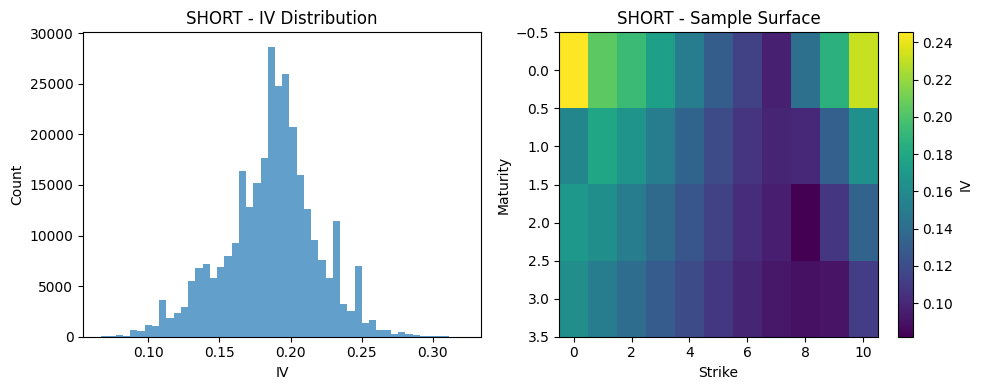


MID TERM:
  Samples: 7000
  IV shape per sample: torch.Size([5, 11])
  IV range: [0.0495, 0.3652]
  IV mean: 0.1930 ± 0.0445


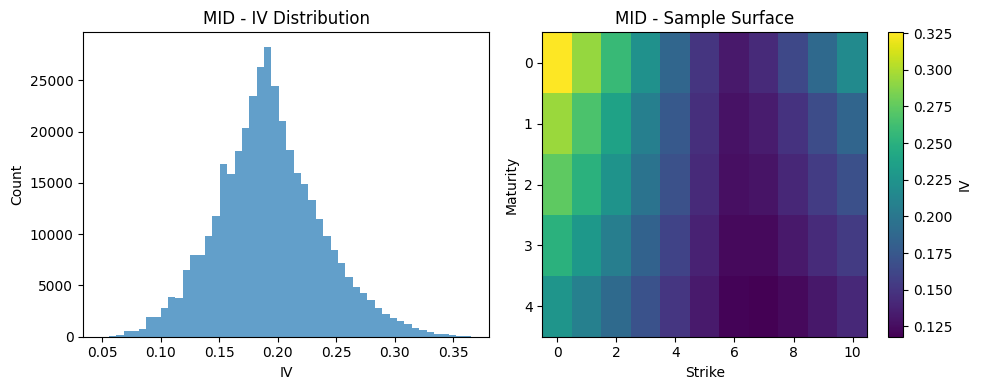


LONG TERM:
  Samples: 7000
  IV shape per sample: torch.Size([4, 11])
  IV range: [0.0283, 0.6961]
  IV mean: 0.2571 ± 0.0965


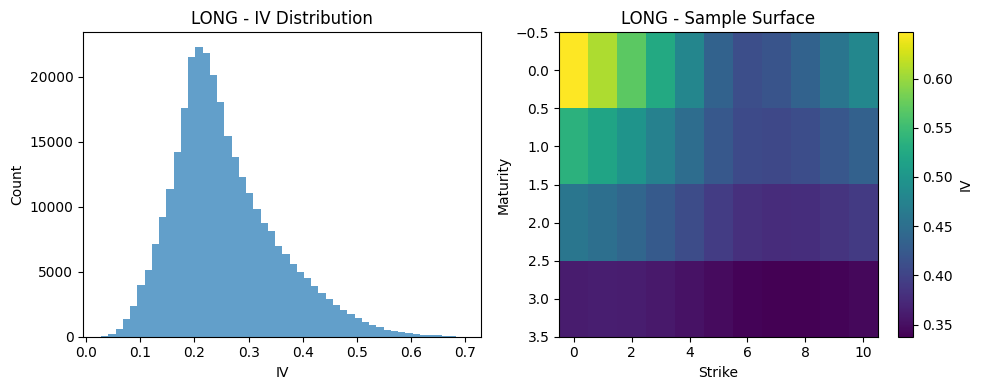


STEP 4: TRAINING WITH CORRECT NORMALIZATION

NORMALIZATION DEBUG - SHORT

Normalized data:
Theta shape: torch.Size([7000, 4])
Theta mean: tensor([-0.0012,  0.0006, -0.0013, -0.0011], device='cuda:0')
Theta std: tensor([1.0004, 0.9991, 0.9999, 1.0014], device='cuda:0')
IV shape: torch.Size([4, 11])
IV mean: -0.0000
IV std: 1.0000

Builder statistics:
Theta mean (builder): tensor([ 0.2501,  1.7495, -0.5247,  0.0900], device='cuda:0')
Theta std (builder): tensor([0.1154, 0.7224, 0.2454, 0.0404], device='cuda:0')
IV mean (builder): 0.1866
IV std (builder): 0.0326

Denormalized data:
Theta range: [-0.9500, 2.9999]
IV range: [0.0670, 0.3214]

NORMALIZATION DEBUG - MID

Normalized data:
Theta shape: torch.Size([7000, 4])
Theta mean: tensor([-0.0012,  0.0006, -0.0013, -0.0011], device='cuda:0')
Theta std: tensor([1.0004, 0.9991, 0.9999, 1.0014], device='cuda:0')
IV shape: torch.Size([5, 11])
IV mean: 0.0000
IV std: 1.0000

Builder statistics:
Theta mean (builder): tensor([ 0.2501,  1.7495, -0

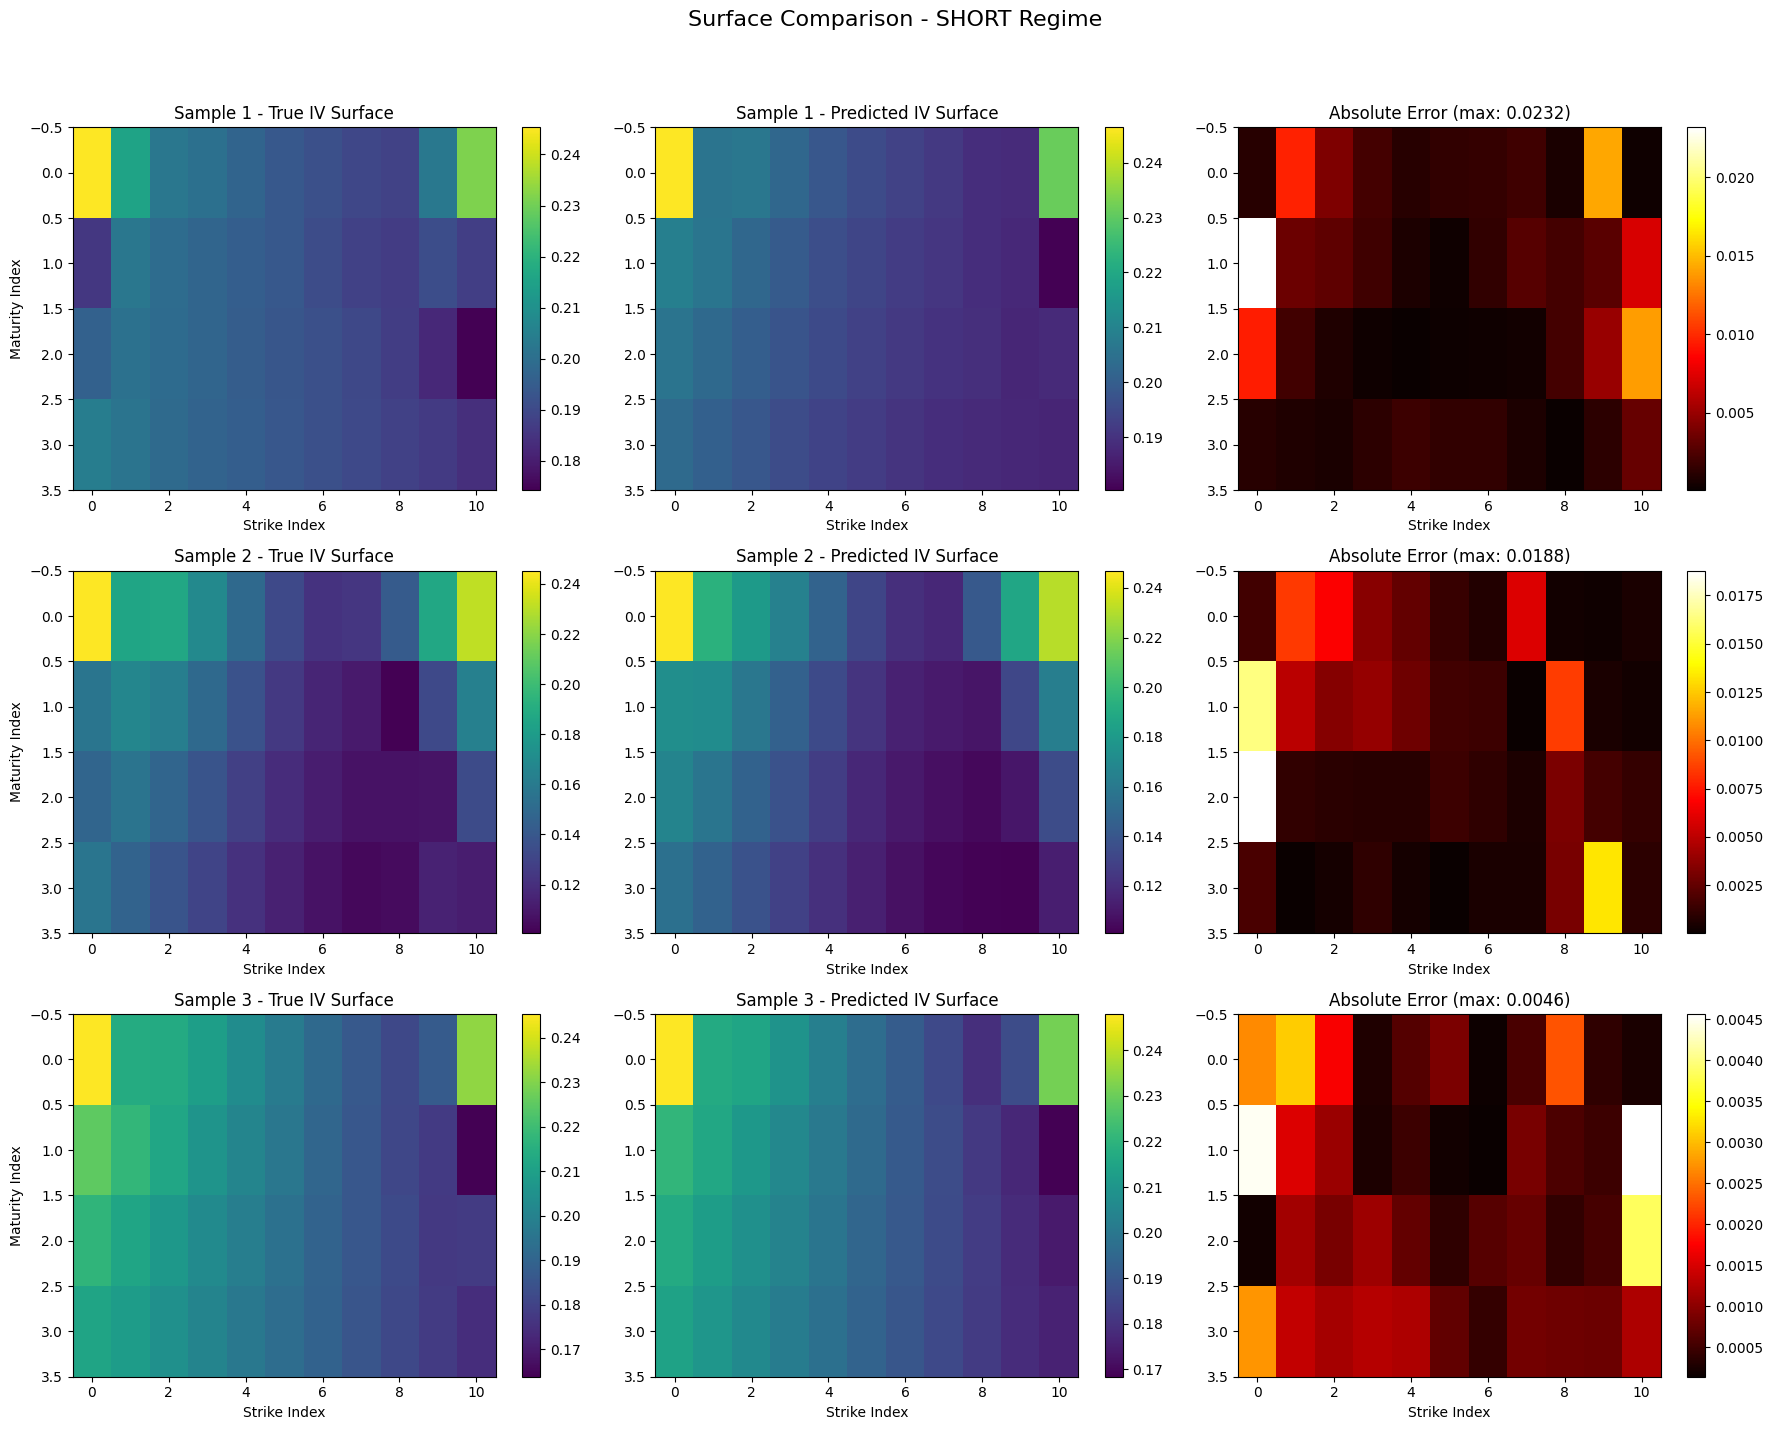

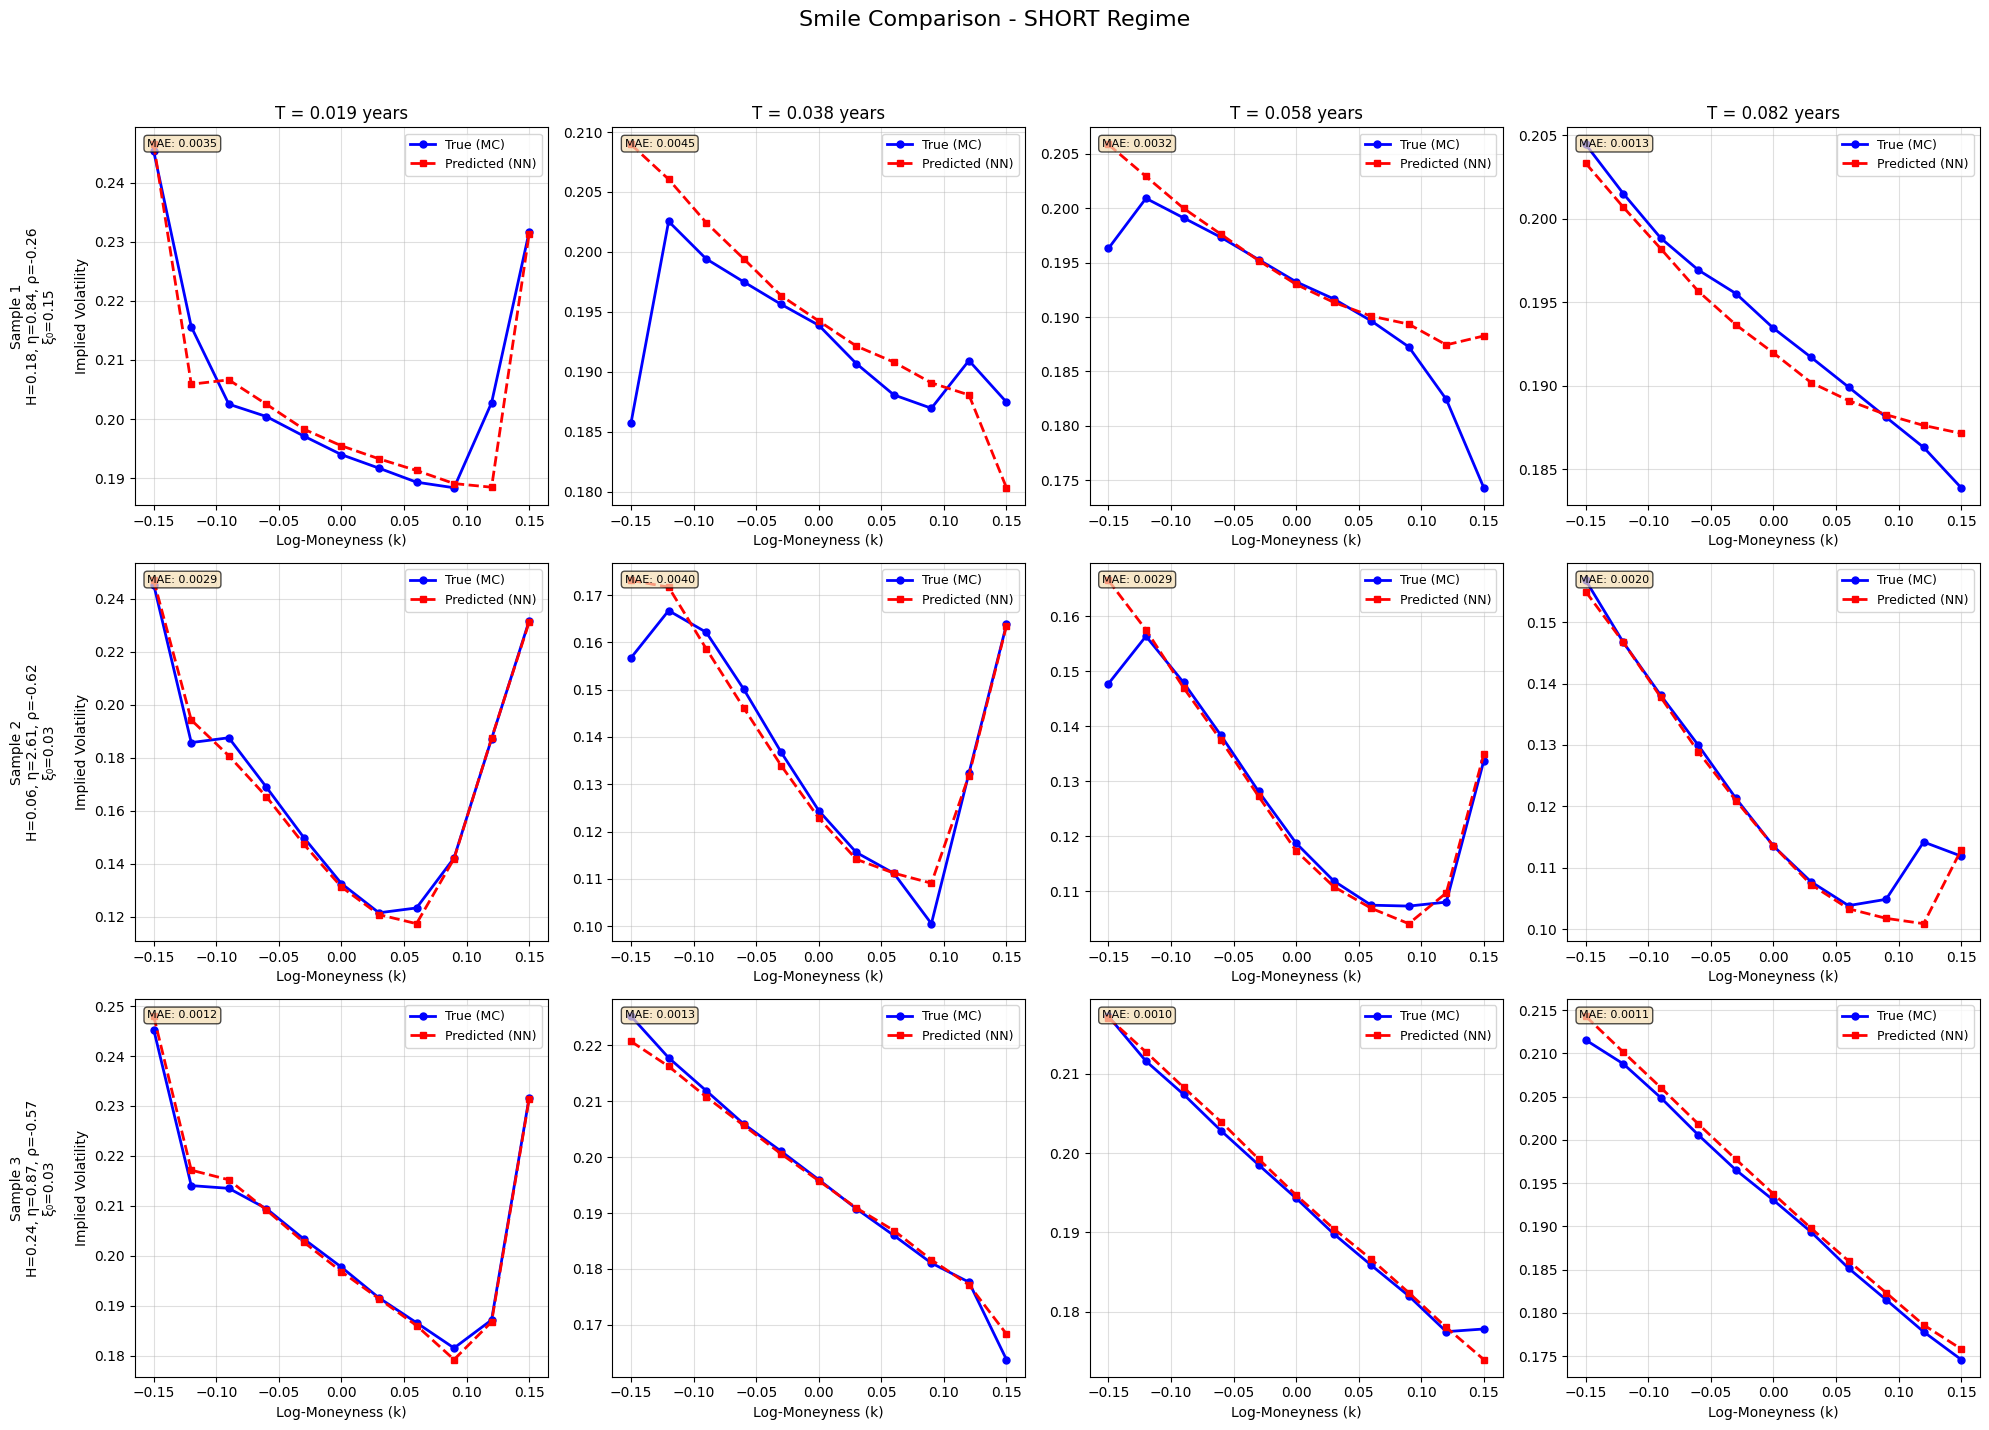


--- Visualizing MID regime ---


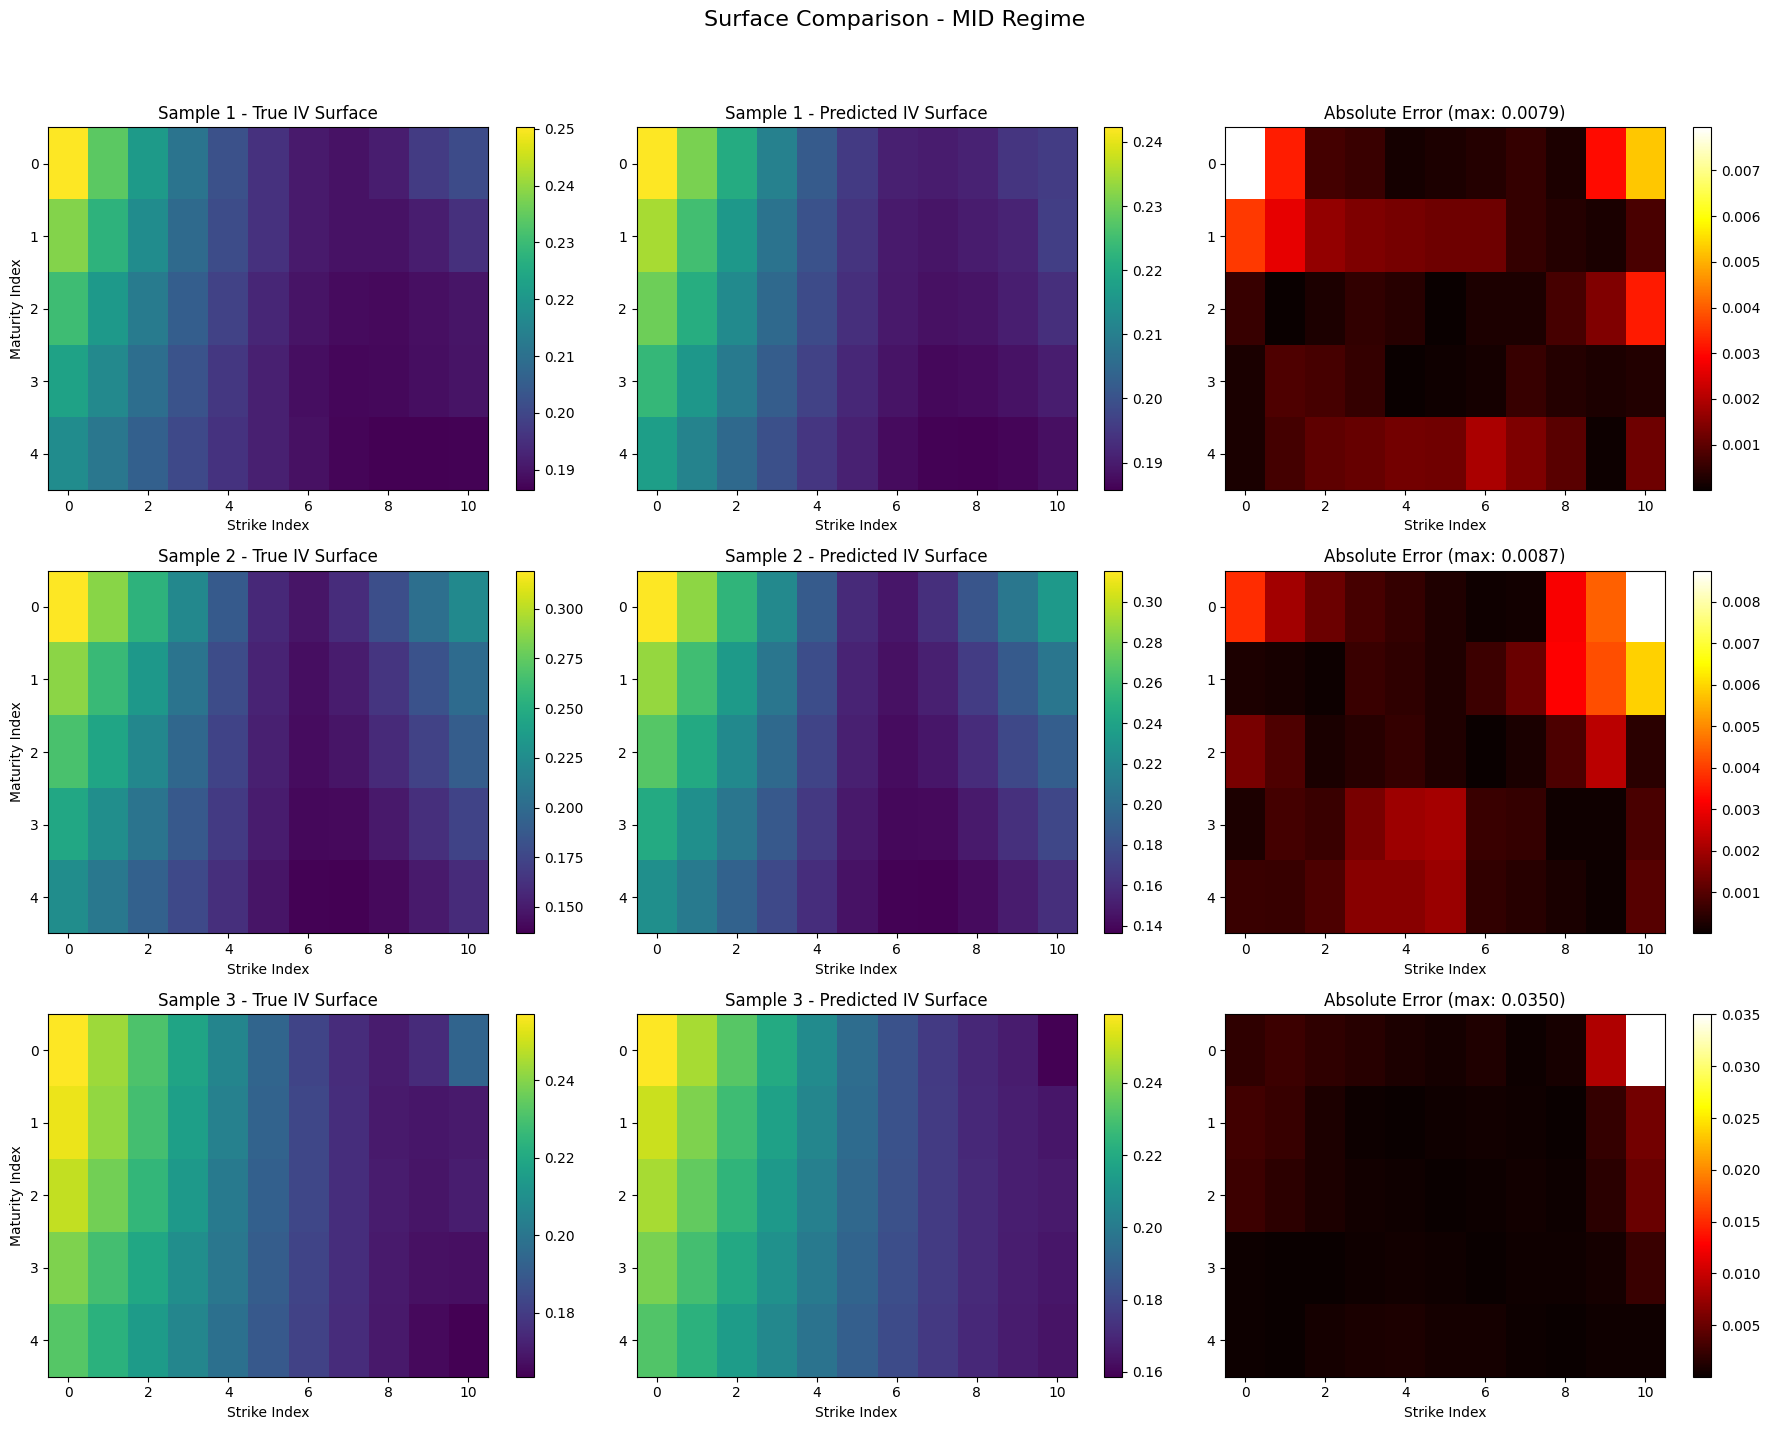

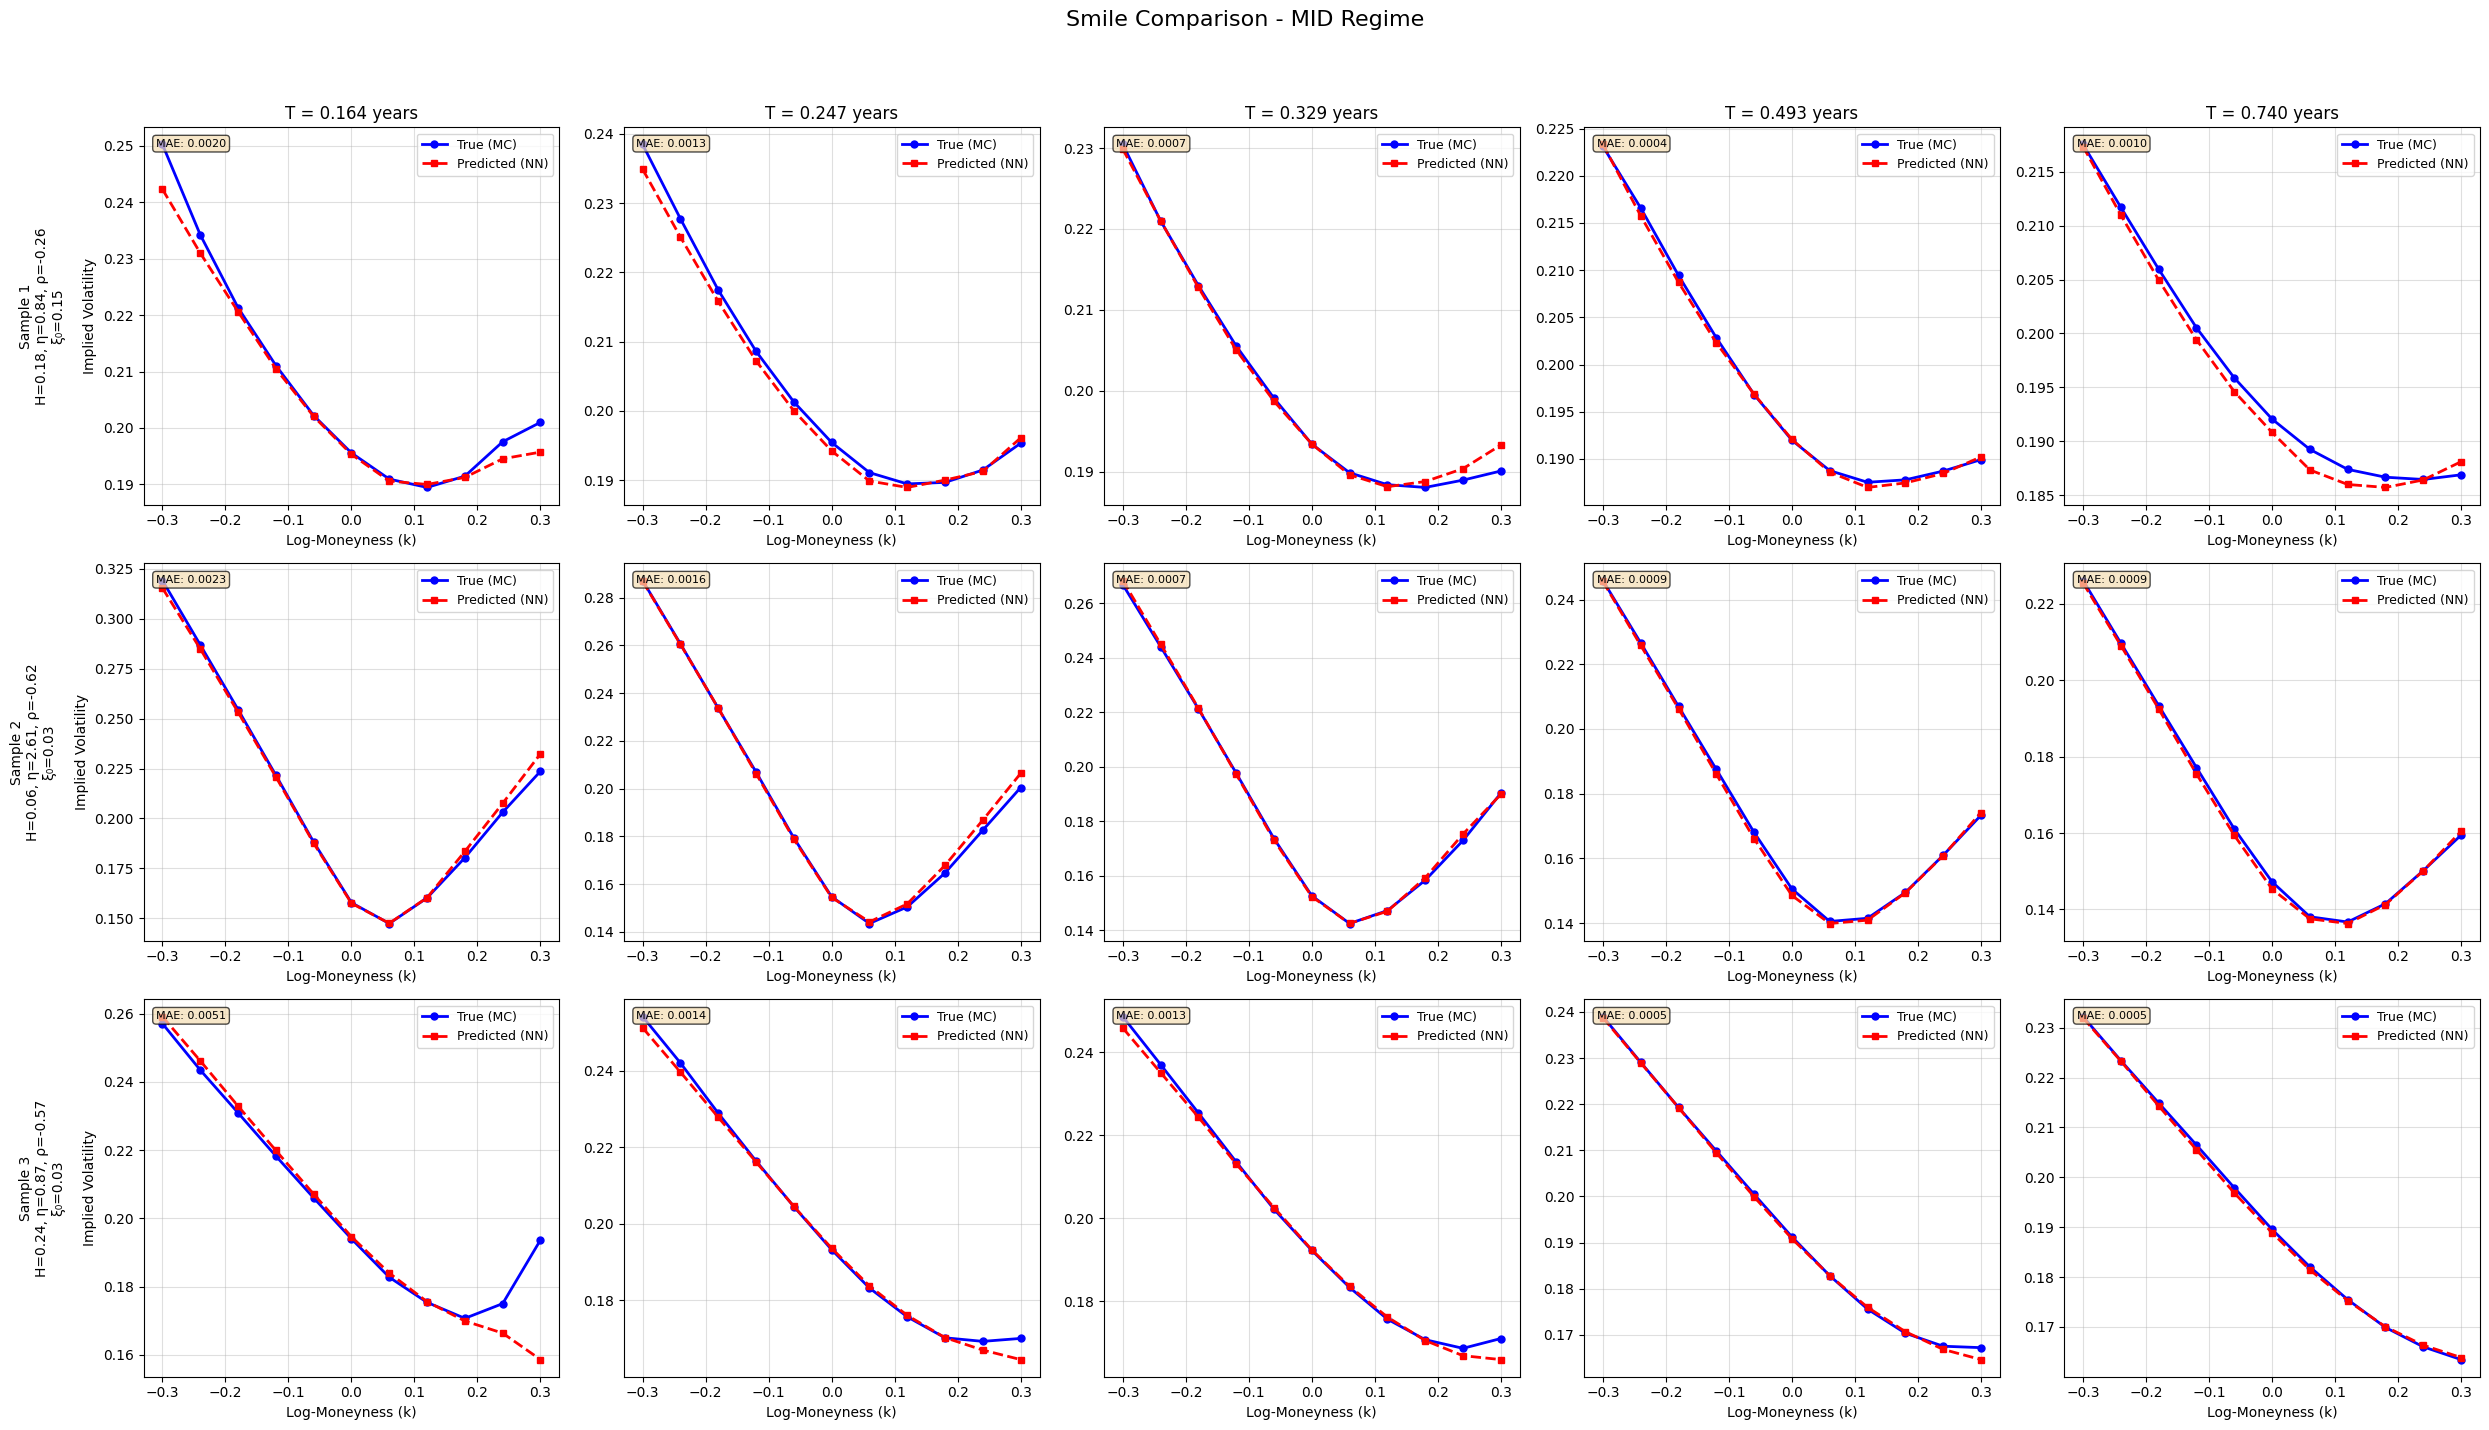


--- Visualizing LONG regime ---


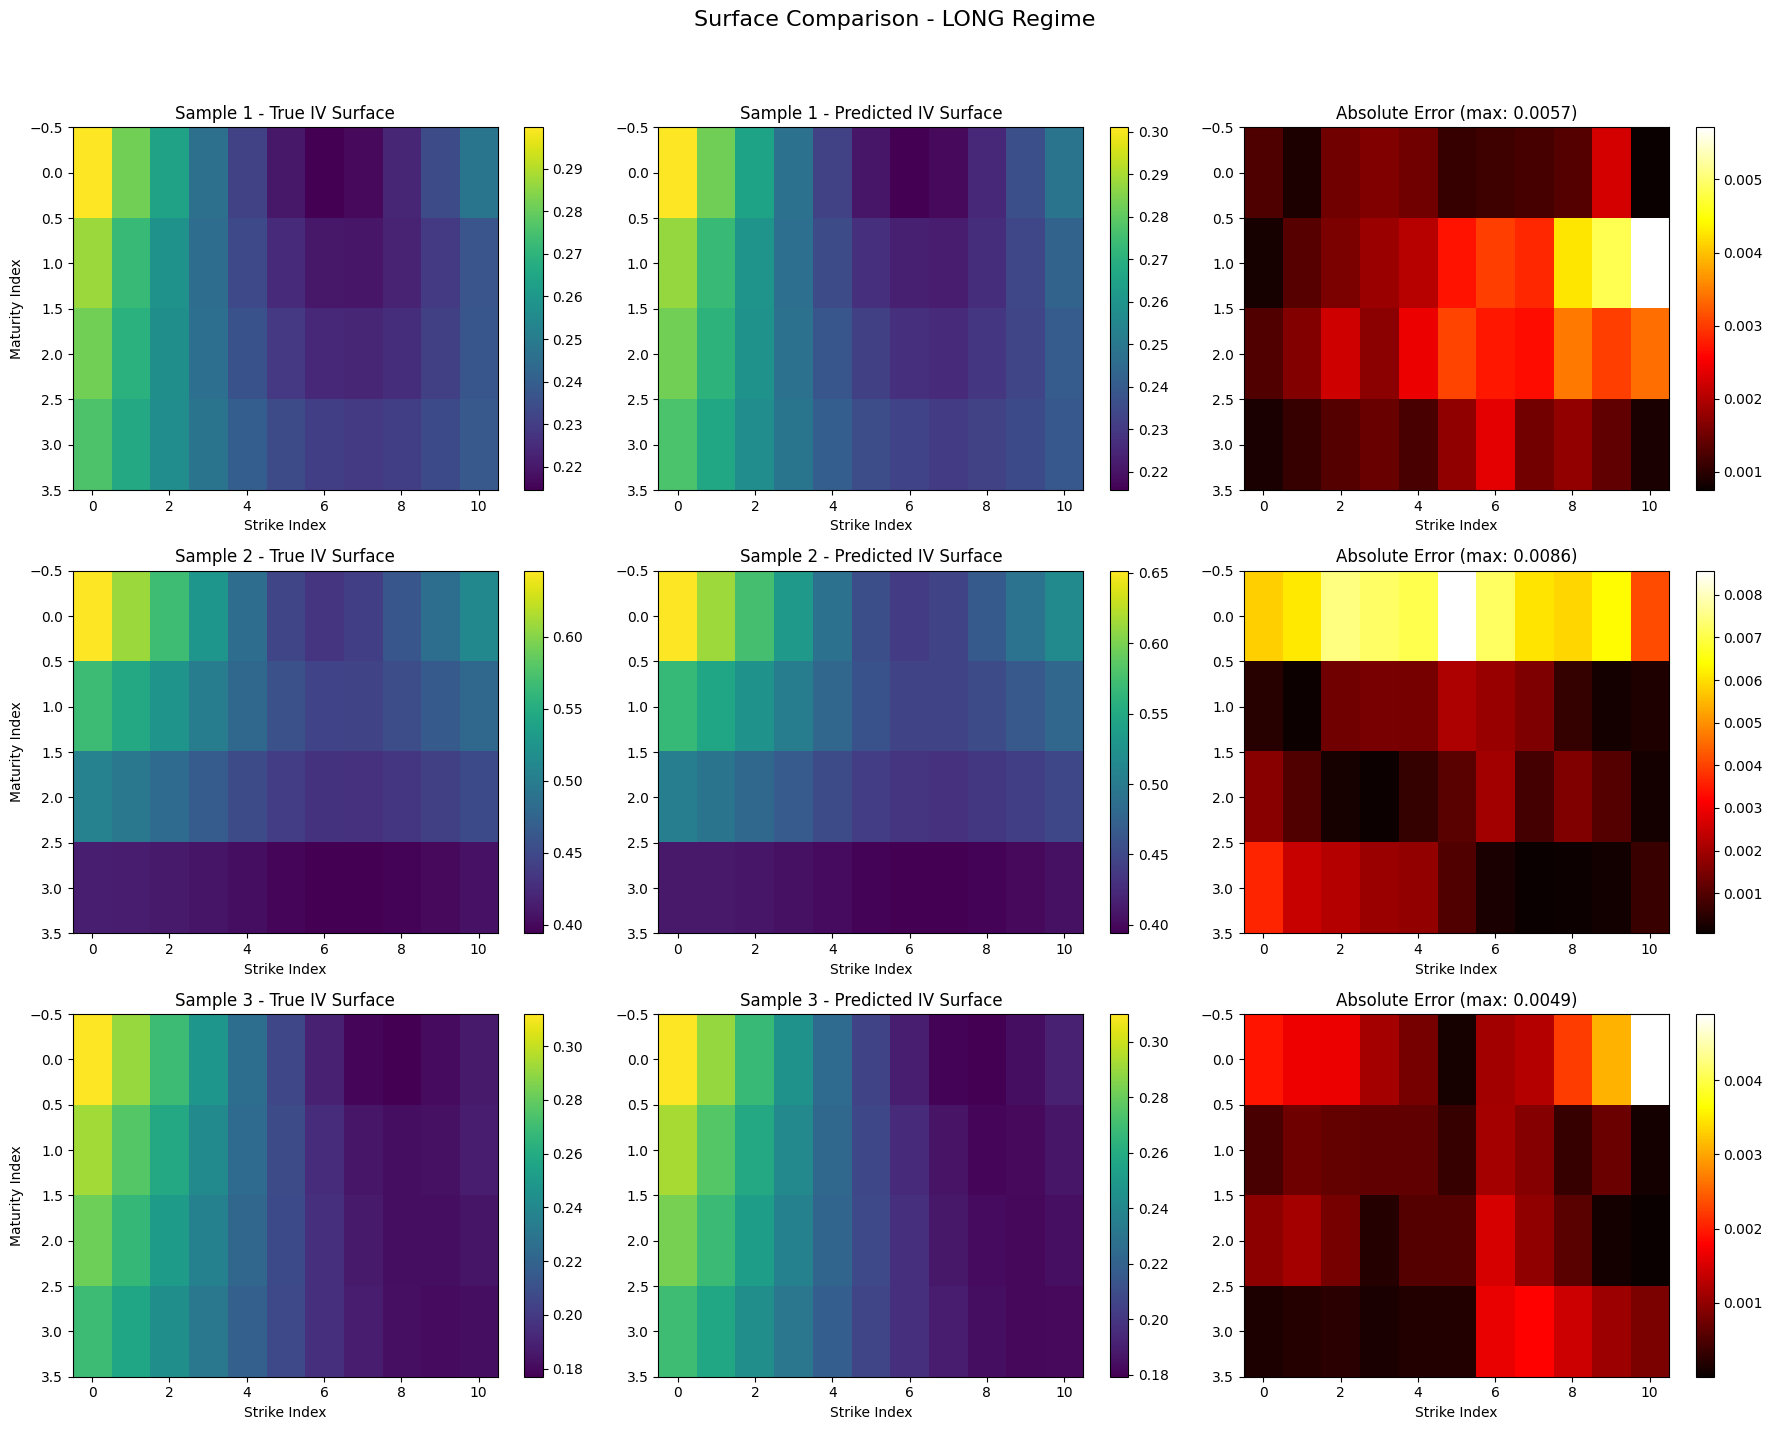

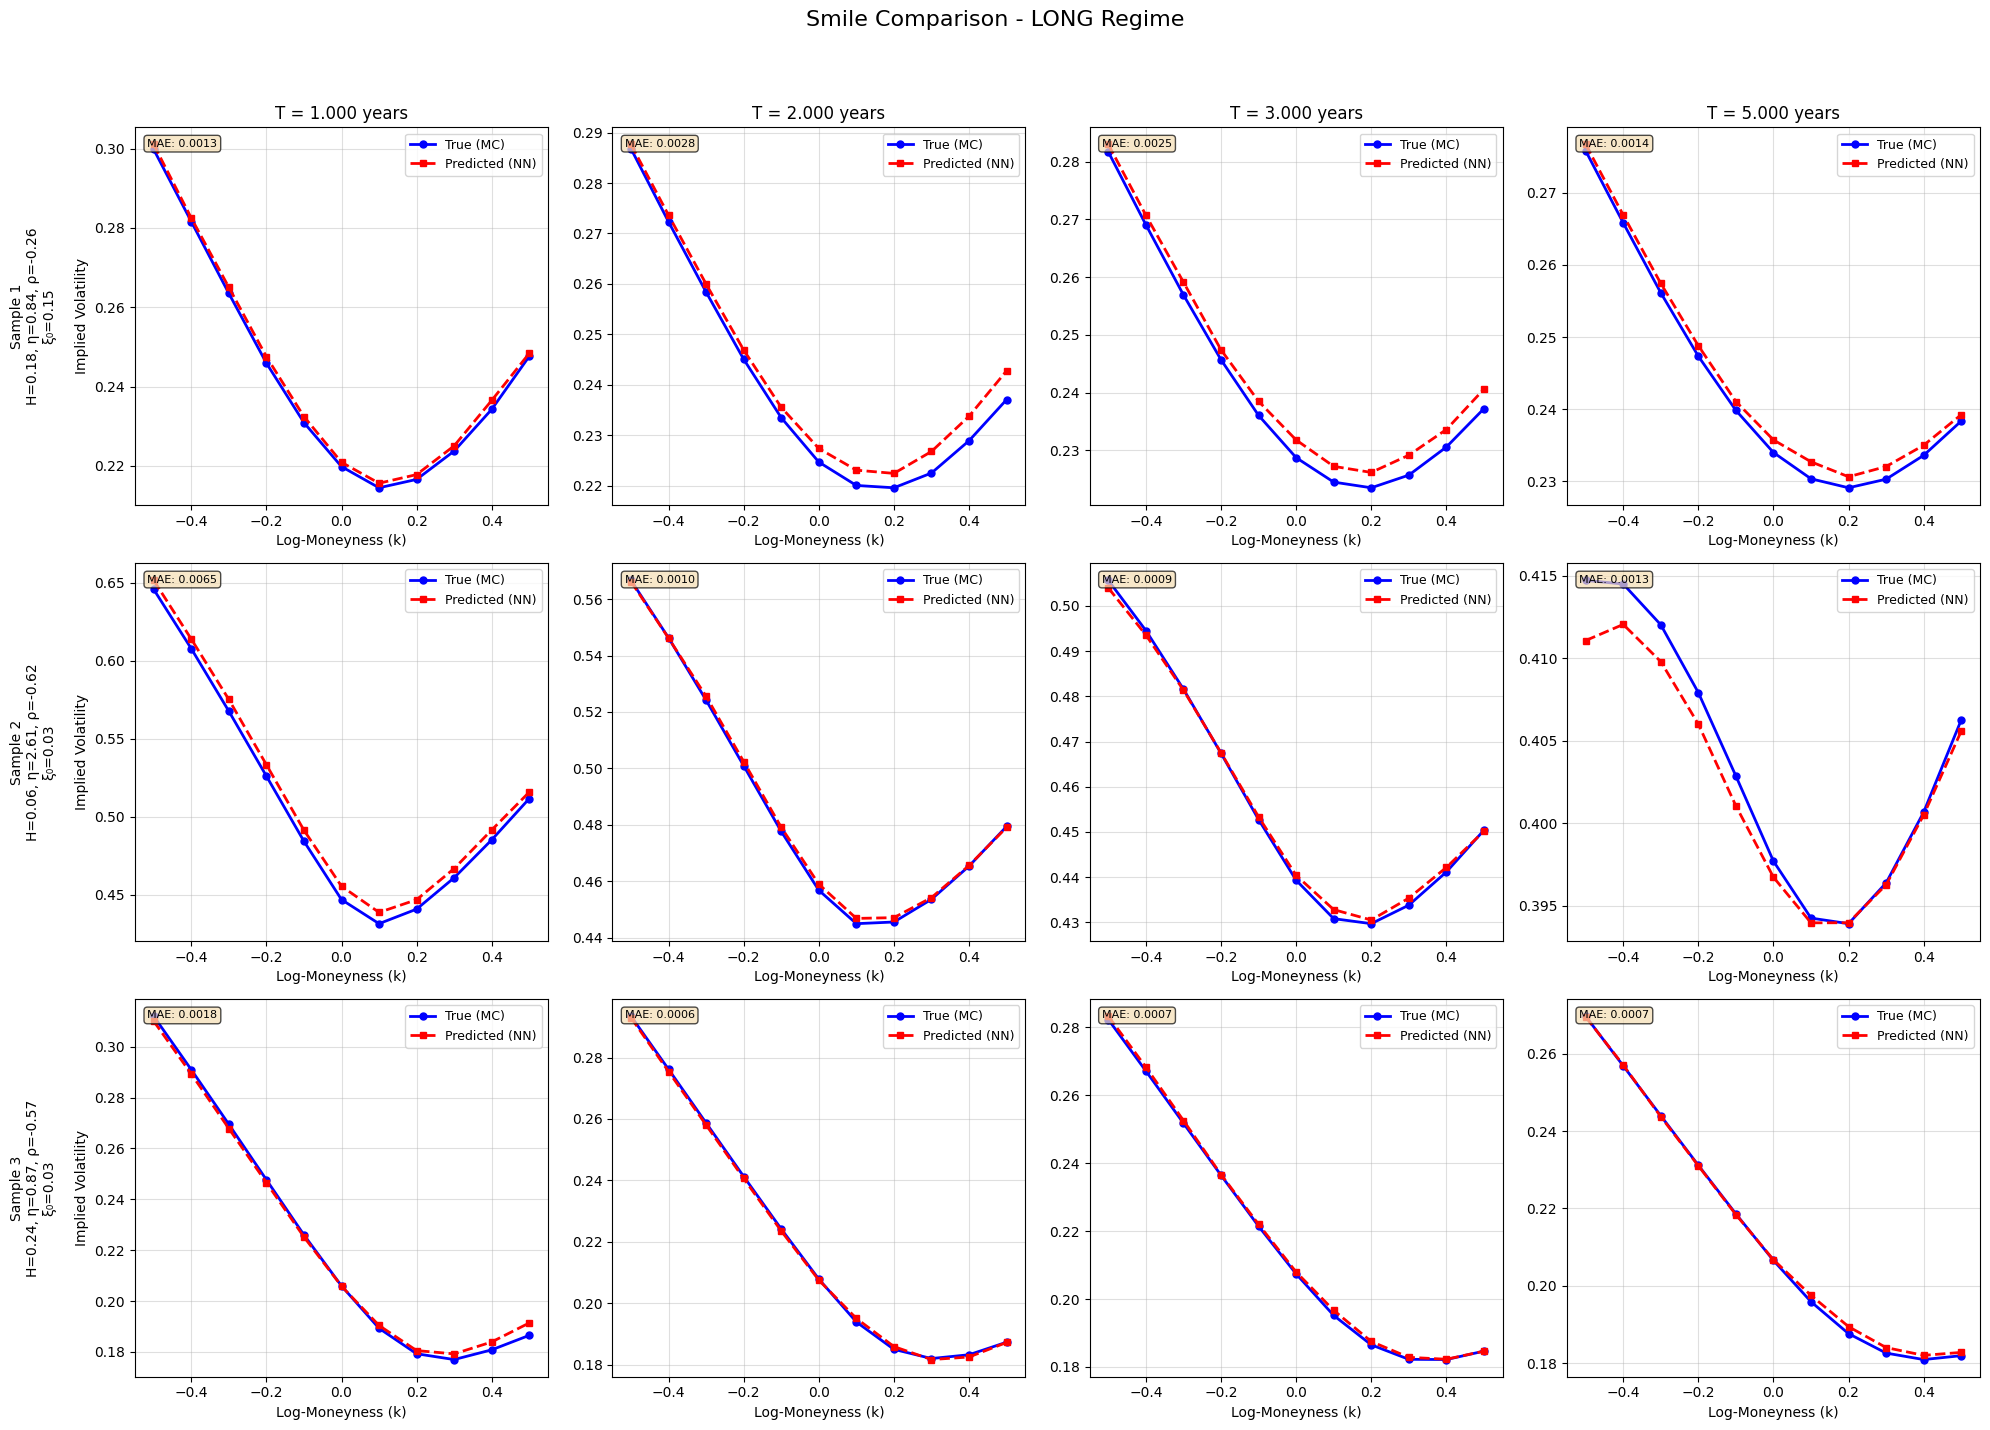

STEP 8: TESTING MODEL LOADING
Loading multi-regime model from config: /content/drive/MyDrive/multi_regime_results_rough_bergomi/models/final/rough_bergomi_multi_regime_config_20250903_161955.json
Creating process (canonical): rough_bergomi

STEP 8: TESTING MODEL LOADING
Loading multi-regime model from config: rough_bergomi_multi_regime_config_20250903_161955.json
✓ Created process: RoughBergomiProcess


RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "6.weight", "6.bias", "8.weight", "8.bias". 
	size mismatch for 0.weight: copying a param with shape torch.Size([30, 4]) from checkpoint, the shape in current model is torch.Size([128, 4]).
	size mismatch for 0.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 2.weight: copying a param with shape torch.Size([30, 30]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for 2.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 4.weight: copying a param with shape torch.Size([30, 30]) from checkpoint, the shape in current model is torch.Size([44, 64]).
	size mismatch for 4.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([44]).

In [ ]:
if torch.cuda.is_available():
    print("GPU found! CUDA will be used.")
    device = 'cuda'
else:
    print("GPU not found. CPU will be used (may be slow).")
    device = 'cpu'

multi_pricer, train_builder, val_builder = run_complete_fixed_example()

print("\nExecution completed!")